<a href="https://colab.research.google.com/github/arsathsm/login-design-front-end-/blob/main/Mnist_2020E010.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import time

In [9]:
def convert(imgs, labels, outfile, n):
    imgf = open(imgs, "rb")
    labelf= open(labels, "rb")
    csv = open(outfile, "w")

    imgf.read(16)
    labelf.read(8)
    images = []

    for i in range(n):
        image = [ord(labelf.read(1))]
        for j in range(28*28):
            image.append(ord(imgf.read(1)))
        images.append(image)

    for image in images:
        csv.write(",".join(str(pix) for pix in image)+"\n")
    imgf.close()
    labelf.close()
    csv.close()

In [11]:
mnist_train_x ="/train-images-idx3-ubyte"
mnist_train_y ="/train-labels-idx1-ubyte"
mnist_test_x ="/t10k-images-idx3-ubyte"
mnist_test_y ="/t10k-labels-idx1-ubyte"

In [13]:
convert(mnist_train_x, mnist_train_y, "/train.csv",60000)
convert(mnist_test_x, mnist_test_y, "/test.csv",1000)

In [15]:
# open the CSV file and read its contents into a list
train_file = open("/train.csv", 'r')
train_list = train_file.readlines()
train_file.close()


In [16]:
len(train_list)


60000

In [17]:
# show a dataset record
# the first number is the label, the rest are pixel colour values (greyscale 0-255)
train_list[100]

'8,0,0,0,0,0,0,0,0,0,1,0,0,18,107,119,103,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,99,155,113,61,118,173,117,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,110,136,0,0,0,0,0,167,159,0,0,2,0,0,0,0,0,0,0,0,0,0,0,1,0,6,0,72,147,0,0,5,0,2,0,0,174,118,0,5,0,0,0,0,0,0,0,0,0,0,0,1,5,0,0,174,4,0,4,0,0,0,0,0,0,204,44,0,4,0,0,0,0,0,0,0,0,0,0,0,8,0,125,128,0,9,0,0,0,0,0,2,0,107,152,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,184,9,0,4,0,0,0,0,0,2,0,0,190,0,0,2,0,0,0,0,0,0,0,1,0,2,0,73,158,0,0,0,0,1,0,0,0,0,4,0,157,79,0,3,1,0,0,0,0,0,2,5,1,0,0,157,98,0,2,0,0,1,0,0,0,0,5,0,121,145,0,0,0,0,0,0,0,0,0,0,0,0,0,231,84,0,2,1,1,0,0,0,0,0,1,0,92,223,16,0,7,4,1,0,0,0,0,0,0,0,38,183,81,0,0,0,2,2,1,2,1,0,1,0,120,226,57,0,0,0,0,0,0,0,173,216,193,213,183,164,167,98,16,0,0,0,0,0,0,0,0,0,107,141,111,91,90,108,50,0,0,0,185,221,217,210,202,222,200,206,202,204,109,27,12,17,61,136,180,221,202,225,208,214,223,240,162,0,0,0,183,220,205,200,193,184,189,182,173,194,215,216,205,207,207,195,185,194,194,203,212,183,193,211,153,0,0,0,190,23

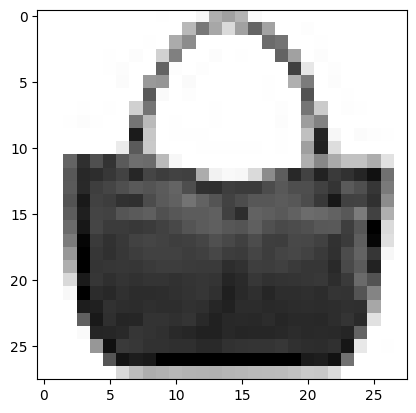

In [19]:
# take the data from a record, rearrange it into a 28*28 array and plot it as an image
all_values = train_list[100].split(',')
image_array = np.asfarray(all_values[1:]).reshape((28,28))
plt.imshow(image_array, cmap='Greys', interpolation='None')

In [20]:
test_file = open("/test.csv", 'r')
test_list = test_file.readlines()
test_file.close()

In [22]:
len(test_list)

1000

In [23]:
class DNN:
  def __init__(self, sizes, epochs, lr):
    self.sizes = sizes
    self.epochs = epochs
    self.lr = lr

    # number of nodes in each layer
    input_layer=self.sizes[0]
    hidden_1=self.sizes[1]
    hidden_2=self.sizes[2]
    output_layer=self.sizes[3]

    self.params = {
        'W1':np.random.randn(hidden_1, input_layer) * np.sqrt(1. / hidden_1),
        'W2':np.random.randn(hidden_2, hidden_1) * np.sqrt(1. / hidden_2),
        'W3':np.random.randn(output_layer, hidden_2) * np.sqrt(1. / output_layer)
    }
  def sigmoid(self, x, derivative=False):
      if derivative:
          return (np.exp(-x))/((np.exp(-x)+1)**2)
      return 1/(1 + np.exp(-x))

  def softmax(self, x, derivative=False):
      # Numerically stable with large exponentials
      exps = np.exp(x - x.max())
      if derivative:
          return exps / np.sum(exps, axis=0) * (1 - exps / np.sum(exps, axis=0))
      return exps / np.sum(exps, axis=0)
  def forward_pass(self, x_train):
      params = self.params

      # input layer activations becomes sample
      params['A0'] = x_train

      # input layer to hidden layer 1
      params['Z1'] = np.dot(params["W1"], params['A0'])
      params['A1'] = self.sigmoid(params['Z1'])

      # hidden layer 1 to hidden layer 2
      params['Z2'] = np.dot(params["W2"], params['A1'])
      params['A2'] = self.sigmoid(params['Z2'])

      # hidden layer 2 to output layer
      params['Z3'] = np.dot(params["W3"], params['A2'])
      params['A3'] = self.softmax(params['Z3'])

      return params['A3']

  def backward_pass(self, y_train, output):
      '''
          This is the backpropagation algorithm, for calculating the updates
          of the neural network's parameters.

          Note: There is a stability issue that causes warnings. This is
                caused  by the dot and multiply operations on the huge arrays.

                RuntimeWarning: invalid value encountered in true_divide
                RuntimeWarning: overflow encountered in exp
                RuntimeWarning: overflow encountered in square
      '''
      params = self.params
      change_w = {}

      # Calculate W3 update
      error = 2 * (output - y_train) / output.shape[0] * self.softmax(params['Z3'], derivative=True)
      change_w['W3'] = np.outer(error, params['A2'])

      # Calculate W2 update
      error = np.dot(params['W3'].T, error) * self.sigmoid(params['Z2'], derivative=True)
      change_w['W2'] = np.outer(error, params['A1'])

      # Calculate W1 update
      error = np.dot(params['W2'].T, error) * self.sigmoid(params['Z1'], derivative=True)
      change_w['W1'] = np.outer(error, params['A0'])

      return change_w

  def update_network_parameters(self, changes_to_w):
      '''
          Update network parameters according to update rule from
          Stochastic Gradient Descent.

          θ = θ - η * ∇J(x, y),
              theta θ:            a network parameter (e.g. a weight w)
              eta η:              the learning rate
              gradient ∇J(x, y):  the gradient of the objective function,
                                  i.e. the change for a specific theta θ
      '''

      for key, value in changes_to_w.items():
          self.params[key] -= self.lr * value

  def compute_accuracy(self, test_data, output_nodes):
      '''
          This function does a forward pass of x, then checks if the indices
          of the maximum value in the output equals the indices in the label
          y. Then it sums over each prediction and calculates the accuracy.
      '''
      predictions = []

      for x in train_list:
          all_values = x.split(',')
          # scale and shift the inputs
          inputs = (np.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01
          # create the target output values (all 0.01, except the desired label which is 0.99)
          targets = np.zeros(output_nodes) + 0.01
          # all_values[0] is the target label for this record
          targets[int(all_values[0])] = 0.99
          output = self.forward_pass(inputs)
          pred = np.argmax(output)
          predictions.append(pred == np.argmax(targets))

      return np.mean(predictions)

  def train(self, train_list, test_list, output_nodes):
      start_time = time.time()
      for iteration in range(self.epochs):
          for x in train_list:
              all_values = x.split(',')
              # scale and shift the inputs
              inputs = (np.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01
              # create the target output values (all 0.01, except the desired label which is 0.99)
              targets = np.zeros(output_nodes) + 0.01
              # all_values[0] is the target label for this record
              targets[int(all_values[0])] = 0.99
              output = self.forward_pass(inputs)
              changes_to_w = self.backward_pass(targets, output)
              self.update_network_parameters(changes_to_w)

          accuracy = self.compute_accuracy(test_list, output_nodes)
          print('Epoch: {0}, Time Spent: {1:.2f}s, Accuracy: {2:.2f}%'.format(
              iteration+1, time.time() - start_time, accuracy * 100
          ))

In [24]:
dnn = DNN(sizes=[784, 128, 64, 10], epochs=10, lr=0.001)
dnn.train(train_list, test_list, 10)

Epoch: 1, Time Spent: 85.58s, Accuracy: 29.93%
Epoch: 2, Time Spent: 171.60s, Accuracy: 31.57%
Epoch: 3, Time Spent: 255.68s, Accuracy: 32.31%
Epoch: 4, Time Spent: 340.64s, Accuracy: 34.13%
Epoch: 5, Time Spent: 425.08s, Accuracy: 36.43%
Epoch: 6, Time Spent: 509.27s, Accuracy: 40.44%
Epoch: 7, Time Spent: 596.20s, Accuracy: 45.88%
Epoch: 8, Time Spent: 679.15s, Accuracy: 50.42%
Epoch: 9, Time Spent: 764.63s, Accuracy: 54.15%
Epoch: 10, Time Spent: 850.20s, Accuracy: 57.42%
